In [1]:
from importlib import reload
import numpy as np 
import matplotlib as mpl
mpl.use('Agg')
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch
plt.ioff()
%matplotlib inline
import seaborn as sns
import pandas as pd
import gseapy
from gseapy.plot import barplot, dotplot
import networkx as nx
import OmicsIntegrator as oi
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
import community 
import pickle
import itertools

import get_binarized_map_of_selected_loci_2 as diff

In [2]:
# Reload modules in case of modifications
reload(diff)

<module 'get_binarized_map_of_selected_loci_2' from '/home/braunger/masterthesis/python_code/compare_hic/get_binarized_map_of_selected_loci_2.py'>

In [3]:
save_dir = '/home/braunger/masterthesis/save/'
hic_dir = save_dir + 'processed_hic_data/'
fig_dir = '/home/braunger/masterthesis/save/figures/compare_hic/'
data_dir = '/home/braunger/masterthesis/data/'

# 1. Binarized maps for HIF1A targets

In [48]:
selected_loci = pd.read_csv(save_dir + 'TF_targets/HIF1A_targets_loci.csv')
DE_genes = pd.read_csv(data_dir + 'de_data/DE_var_p_n_200.csv')
DE_genes['DE'] = 'True'
DE_genes = DE_genes[['gene', 'DE']]

selected_loci = selected_loci.merge(DE_genes, how = "left")
selected_loci['DE'] = selected_loci['DE'].fillna('False')
selected_loci.head()

HIF1A_locus = selected_loci.loc[selected_loci['gene'] == "HIF1A", 'locus'].item()

# load TF targets
tf_targets = pd.read_csv(save_dir + 'TF_targets/' + 'TF_targets_anno.csv', sep = ',')

## a) Binarized maps for young and old fibroblasts

In [35]:
IMR90 = pd.read_csv(hic_dir+'processed_hic_data_IMR90/binarized_maps/HIF1A_subset.csv', index_col = 0)
old_fibroblasts = pd.read_csv(hic_dir+'processed_hic_data_old_fibroblasts/binarized_maps/HIF1A_subset.csv', index_col = 0)

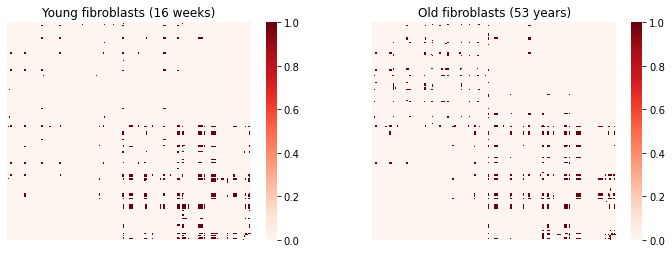

In [36]:
%matplotlib inline
diff.plot_binarized_maps(IMR90,old_fibroblasts)
plt.savefig(fig_dir + 'binarized_hic_HIF1A.png')

<Figure size 432x288 with 0 Axes>

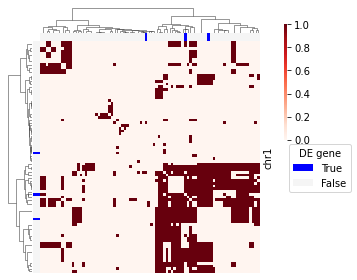

In [37]:
# Young fibroblast clustering
young_sub = IMR90.loc[(IMR90!=0).any(axis=1), (IMR90!=0).any(axis=1)]
diff.plot_clustered_anno(young_sub, selected_loci)

/home/braunger/miniconda3/envs/pcst/lib/python3.7/site-packages/seaborn/matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


<Figure size 432x288 with 0 Axes>

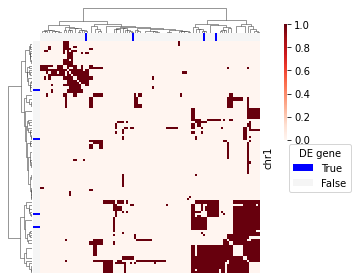

In [38]:
# Old fibroblast clustering
old_sub = old_fibroblasts.loc[(old_fibroblasts!=0).any(axis=1), (old_fibroblasts!=0).any(axis=1)]
diff.plot_clustered_anno(old_sub, selected_loci)

## b) Clustering of the difference matrix

In [ ]:
# Differences between young and old
diff_map = IMR90 - old_fibroblasts

# Color map: including the similarities
color_map = IMR90 + 2 * old_fibroblasts

# Filter for loci that are contained in a LAS in at least one of the celltypes
color_map = color_map.loc[(color_map!=0).any(axis=1), (color_map!=0).any(axis=1)]
diff_map = diff_map.loc[color_map.index, color_map.index]

# Save results
color_map.to_csv(hic_dir + 'difference_maps/comp_map_HIF1A_targets.csv')
diff_map.to_csv(hic_dir + 'difference_maps/diff_HIF1A_targets.csv')

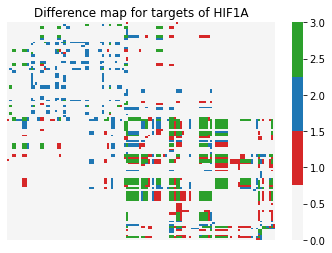

In [40]:
# Plot unclustered difference map
# define colors
palette = sns.color_palette("tab10")
colors = ['whitesmoke', palette[3], palette[0], palette[2]]
cmap = ListedColormap(colors)

plt.figure()
sns.heatmap(color_map, cmap = cmap, xticklabels=False, yticklabels=False)
plt.title("Difference map for targets of HIF1A")
plt.ylabel("")

plt.savefig(fig_dir + 'difference_map_HIF1A.png')
plt.show()

In [41]:
# Define distance metric for the color map (based on the number of differences in young and old)
def color_dist(l1, l2): # distance between a pair of loci
    if l1 == l2:
        diff = 0 
    elif (l1 == 0) & (l2 == 3):
        diff = 2
    elif (l1 == 3) & (l2 == 0):
        diff = 2
    elif (l1 == 1) & (l2 == 2):
        diff = 2
    elif (l1 == 2) & (l2 == 1):
        diff = 2
    else: 
        diff = 1
    return diff

def color_metric(r1, r2): # metric to calculate distance between two row vectors
    dist = [color_dist(r1[ix], r2[ix]) for ix in range(len(r1))]
    return np.mean(dist)

<Figure size 432x288 with 0 Axes>

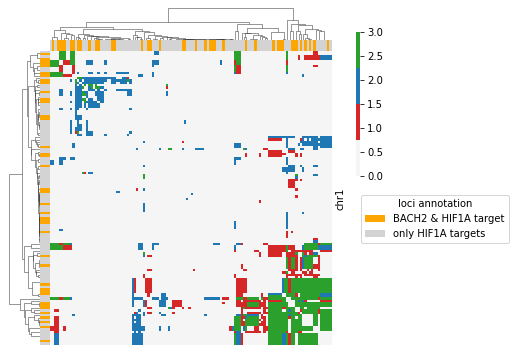

In [51]:
# Plot clustered differences with annotation for BACH2
# color annotation bar
BACH2_loci = set(tf_targets.loc[tf_targets['TF'] == "BACH2", 'locus'])
color_dict = {}
for loc in color_map.columns:
    if loc in BACH2_loci:
        color_dict[loc] = 'orange'
    else:
        color_dict[loc] = 'lightgrey'
color_rows = pd.Series(color_dict)

plt.figure()
p = sns.clustermap(color_map,
               method='complete',
               metric=color_metric,
               row_cluster=True, col_cluster=True,
               figsize=(5,5),
               xticklabels=False, yticklabels=False,
               cmap=cmap, cbar_pos=(1, 0.5, 0.01, .4),
               vmin=0, vmax=3,
               dendrogram_ratio=(.1, .1), 
               row_colors= [color_rows], col_colors = [color_rows])

# add legend
handles = [Patch(facecolor='orange'), Patch(facecolor='lightgrey')]
plt.legend(handles, ['BACH2 & HIF1A target', 'only HIF1A targets'], title='loci annotation',
           bbox_transform=plt.gcf().transFigure, bbox_to_anchor=(1., 0.3, 1., .102), loc='lower left')

plt.savefig(fig_dir+'clustered_diff_map_HIF1A.png')
plt.show()

/home/braunger/miniconda3/envs/pcst/lib/python3.7/site-packages/ipykernel_launcher.py:3: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  This is separate from the ipykernel package so we can avoid doing imports until


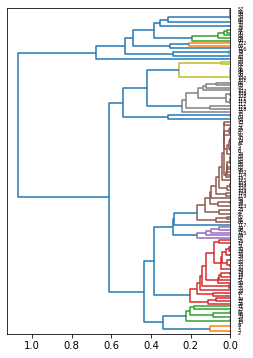

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19] [ 4  7 25  5 39  1  2  1 12  8  2  1  2  1  5  2  5  1  1]


In [67]:
# Hierarchical clustering
# create dendrogram
dend = linkage(color_map, method='complete', metric=color_metric)
plt.figure(figsize = (4, 6))
dendrogram(dend, orientation = "left", color_threshold = 0.28)
plt.show()

clusters = fcluster(dend, 0.28, criterion = 'distance')
loci_clusters = pd.DataFrame({'locus': diff_map.index, 'cluster': clusters})
loci_clusters['chrom'] = loci_clusters['locus'].str.split('_').str[1]
loci_clusters = loci_clusters.merge(selected_loci, how = "left", on = 'locus')
loci_clusters.to_csv(hic_dir + 'difference_maps/hierarchical_clusters_HIF1A.csv', index = False)

unique, counts = np.unique(clusters, return_counts=True)
print(unique, counts)

In [66]:
# Enrichment of the loci in one cluster
loci = loci_clusters.loc[loci_clusters['cluster'] == 3, 'locus']
selected_genes = selected_loci.loc[selected_loci['locus'].isin(loci), 'gene']

# GSEA on old genes
enr = gseapy.enrichr(gene_list= selected_genes, 
                     gene_sets='GO_Biological_Process_2021', 
                     description='',  format='png',
                     verbose=False)
# Visualize results
#enr.results.head(5)
barplot(enr.res2d, title='Cluster 9',
        cutoff=0.05, top_term=10, figsize=(7, 5), color='salmon')

2022-08-10 14:18:10,149 Warning: No enrich terms using library GO_Biological_Process_2021 when cutoff = 0.05


In [63]:
pd.Series([loc.split("_")[1] for loc in loci]).value_counts().rename_axis('chromosomes').reset_index(name='number of loci').transpose()

,0,1,2,3,4,5,6,7
chromosomes,17,10,16,22,15,11,9,20
number of loci,11,7,7,4,3,2,1,1
